> 참고자료: https://a292run.tistory.com/entry/Facial-Expression-Recognition-with-Keras-1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive/iitp/Facial-Expression-Recognition/dataprocessing

/content/drive/MyDrive/iitp/Facial-Expression-Recognition/dataprocessing


In [35]:
from tqdm import tqdm
import re
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import random
import keras
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [8]:
data = pd.read_csv('../data/icml_face_data.csv')

In [9]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label
  
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [10]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [11]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [12]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [13]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [27]:
model3 = keras.models.Sequential()

model3.add(keras.layers.Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dropout(0.25))

model3.add(keras.layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dropout(0.25))

model3.add(keras.layers.Conv2D(256, (5, 5),padding='same', activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.MaxPool2D((2, 2),padding="same"))
model3.add(keras.layers.Dropout(0.25))


model3.add(keras.layers.Flatten())

model3.add(keras.layers.Dense(128))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Activation('relu'))
model3.add(keras.layers.Dropout(0.25))

model3.add(keras.layers.Dense(256))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Activation('relu'))
model3.add(keras.layers.Dropout(0.25))

model3.add(keras.layers.Dense(7, activation='softmax'))

In [28]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        128       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 48, 48, 128)      

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

In [32]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
history3 = model3.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_3'),
                    epochs=30,
                    batch_size=64)

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.7317 - accuracy: 0.3261
Epoch 1: val_accuracy improved from -inf to 0.35525, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 47s 105ms/step - loss: 1.7317 - accuracy: 0.3261 - val_loss: 1.6353 - val_accuracy: 0.3553
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.4218 - accuracy: 0.4518
Epoch 2: val_accuracy improved from 0.35525 to 0.48036, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 46s 102ms/step - loss: 1.4218 - accuracy: 0.4518 - val_loss: 1.3316 - val_accuracy: 0.4804
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.2533 - accuracy: 0.5246
Epoch 3: val_accuracy improved from 0.48036 to 0.52020, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 45s 101ms/step - loss: 1.2533 - accuracy: 0.5246 - val_loss: 1.2339 - val_accuracy: 0.5202
Epoch 4/30
449/449 [===========

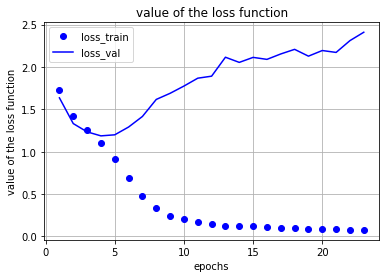

In [36]:
loss = history3.history['loss']
loss_val = history3.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [39]:
train_loss, train_acc = model3.evaluate(train_images, train_labels)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model3.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model3.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 14s 14ms/step - loss: 0.0090 - accuracy: 0.9971
Train Accuracy: 99.71089363098145


113/113 [==============================] - 2s 14ms/step - loss: 2.5076 - accuracy: 0.5520
Test Accuracy: 55.19643425941467


113/113 [==============================] - 2s 13ms/step - loss: 2.4091 - accuracy: 0.5587
Validation Accuracy: 55.86514472961426


In [40]:
pred_test_labels3 = model3.predict(test_images)

## 결과 확인하기

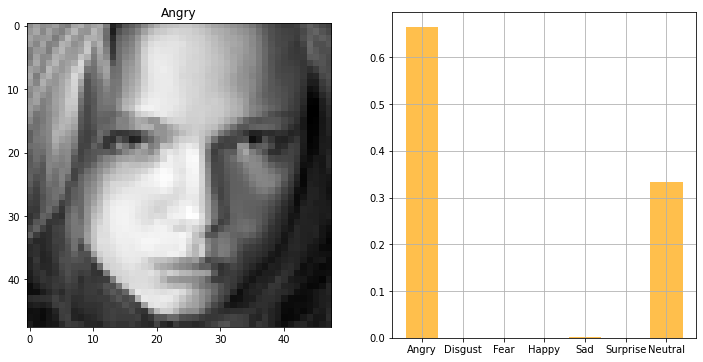

In [44]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 22)